# Data Preprocesssing

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [30]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCH=50

In [31]:
# download into tf.dataset, due to the incorporation of batches
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)


Found 2152 files belonging to 3 classes.


In [32]:
# to see which classes
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Basically the folder names are class names

In [33]:
len(dataset)

68

as its 68*32=2176 images, the last batch is not perfect so its showing different

In [34]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape) #image_batch has 32 images, and imag_batch[0]-- is the first image, its tensor, for converting into numpy we add.numpy()
    print(label_batch.numpy()) # for converting into numpy 

(32, 256, 256, 3)
[1 1 0 1 1 2 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 2]


In [35]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy()) # its a tensor, for converting into numpy we add .numpy()

[[[182. 184. 197.]
  [180. 182. 195.]
  [181. 183. 196.]
  ...
  [193. 191. 202.]
  [192. 190. 201.]
  [193. 191. 202.]]

 [[176. 178. 191.]
  [175. 177. 190.]
  [178. 180. 193.]
  ...
  [191. 189. 200.]
  [190. 188. 199.]
  [190. 188. 199.]]

 [[171. 173. 186.]
  [171. 173. 186.]
  [175. 177. 190.]
  ...
  [188. 186. 197.]
  [187. 185. 196.]
  [186. 184. 195.]]

 ...

 [[127. 124. 133.]
  [145. 142. 151.]
  [122. 119. 128.]
  ...
  [134. 130. 147.]
  [131. 127. 144.]
  [106. 102. 119.]]

 [[137. 134. 143.]
  [139. 136. 145.]
  [136. 133. 142.]
  ...
  [121. 117. 134.]
  [100.  96. 113.]
  [126. 122. 139.]]

 [[148. 145. 154.]
  [130. 127. 136.]
  [133. 130. 139.]
  ...
  [122. 118. 135.]
  [128. 124. 141.]
  [101.  97. 114.]]]


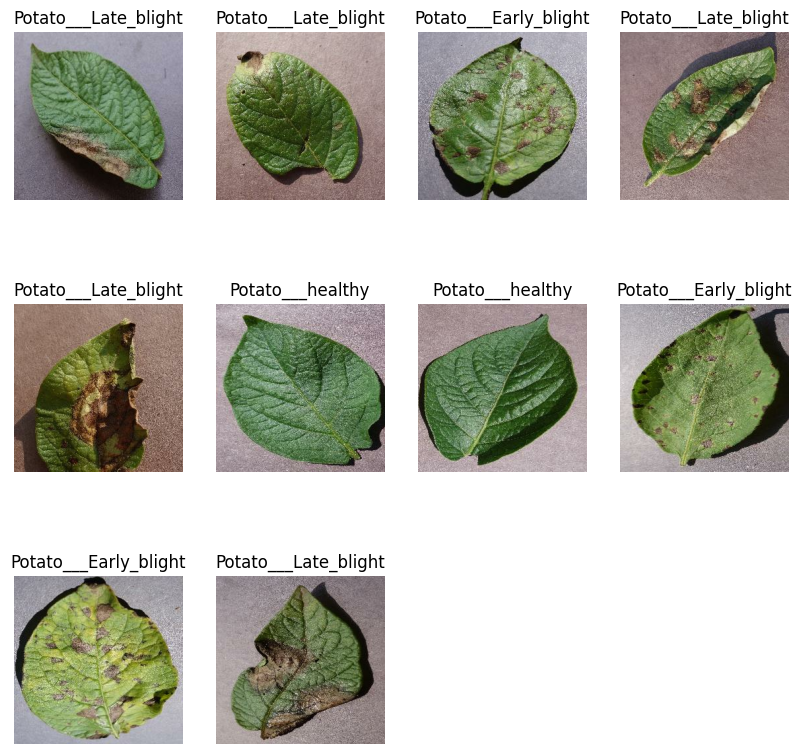

In [36]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))# we converted it to int from float
        plt.axis("off") # for removing the numbers of the axis
        plt.title(class_names[label_batch[i]]) # seeing the label of it

In [38]:
# split our dataset into training and testing data
# 80$ is training
# 20% ==> 10% is validation, rest 10% is testing
# validation after each epoch would be done on the validation dataset, testing is to predicting the performance
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [46]:
train_ds=dataset.take(54)
len(train_ds)

54

In [47]:
test_ds=dataset.skip(54) # would take the remaining after the 54, this that 20%, not the actual testing dataset
len(test_ds)

14

In [48]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [49]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [50]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [68]:
# we want to wrap all the things we did abpve into a nice looking function

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, shuffle= True, test_split=0.1):
    
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle( buffer_size=800,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [69]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [70]:
len(train_ds)

54

In [71]:
len(val_ds)

6

In [76]:
# caching , fast as it will keep the images in the memory after one iteration has been finished
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # if CPU is busy training then prefetch will laod the next batch
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# datasets are optimised for training performance

In [87]:
#0-255, to 0-1 so we do by normalizing, created layers
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255) # for rescaling
])

In [88]:
# data augmentation, to make it more robust. As if we have an rotated image our model knows how to handle it
# created layers+
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.25)
])

# Model Building

In [90]:
# convolutution, pooling, dense/fully connected layers, dropout.
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3 # early, healthy, late
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape), # convolution layer
    layers.MaxPooling2D((2,2)), #pooling layer
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    
    
    
    
    # now we want to flatten it
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax') # as we need probability of each class in the output layer
    
])

model.build(input_shape=input_shape)

In [91]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_33 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [92]:
# compiling
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'], # tracking the traininig the process
)

In [94]:
EPOCHS=50
history = model.fit( # we store the history, in a variable so that we can plot it later
    
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds, # during each epoch, it tracks the training process


)

Epoch 1/50

54/54 [==============================] - 95s 2s/step - loss: 1.9165 - accuracy: 0.4705 - val_loss: 0.8320 - val_accuracy: 0.6302
Epoch 2/50
54/54 [==============================] - 75s 1s/step - loss: 0.8502 - accuracy: 0.6128 - val_loss: 0.7010 - val_accuracy: 0.6823
Epoch 3/50
54/54 [==============================] - 77s 1s/step - loss: 0.6356 - accuracy: 0.7321 - val_loss: 0.4140 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 97s 2s/step - loss: 0.4469 - accuracy: 0.8108 - val_loss: 0.5264 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 92s 2s/step - loss: 0.3473 - accuracy: 0.8565 - val_loss: 0.4948 - val_accuracy: 0.7812
Epoch 6/50
54/54 [==============================] - 87s 2s/step - loss: 0.3288 - accuracy: 0.8750 - val_loss: 0.2492 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 94s 2s/step - loss: 0.2342 - accuracy: 0.9080 - val_loss: 0.3331 - val_accuracy: 0.8802
Epoch 8/50
54/54 [=

In [96]:
# testing dataset
scores=model.evaluate(test_ds)

8/8 [==============================] - 8s 508ms/step - loss: 0.0096 - accuracy: 0.9961


In [97]:
# playing with history parameter
history

In [98]:
# tensorflow callbacks history
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [100]:
history.history.keys() # these many parameters we have, and for each parameter we have 50values

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [101]:
len(history.history['accuracy'])

50

In [95]:
history.history['accuracy']

[0.4704861044883728,
 0.6128472089767456,
 0.7320601940155029,
 0.8107638955116272,
 0.8564814925193787,
 0.875,
 0.9079861044883728,
 0.9207175970077515,
 0.9311342835426331,
 0.9461805820465088,
 0.9380787014961243,
 0.9438657164573669,
 0.9479166865348816,
 0.9415509104728699,
 0.9282407164573669,
 0.9432870149612427,
 0.9525462985038757,
 0.9583333134651184,
 0.9444444179534912,
 0.9525462985038757,
 0.9606481194496155,
 0.9496527910232544,
 0.921875,
 0.9432870149612427,
 0.9612268805503845,
 0.9728009104728699,
 0.9641203880310059,
 0.9675925970077515,
 0.9629629850387573,
 0.9675925970077515,
 0.9704861044883728,
 0.96875,
 0.9849537014961243,
 0.9785879850387573,
 0.9357638955116272,
 0.9728009104728699,
 0.9728009104728699,
 0.9589120149612427,
 0.9693287014961243,
 0.9762731194496155,
 0.9762731194496155,
 0.9745370149612427,
 0.9762731194496155,
 0.9855324029922485,
 0.9855324029922485,
 0.9814814925193787,
 0.9855324029922485,
 0.984375,
 0.9837962985038757,
 0.993634283542

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

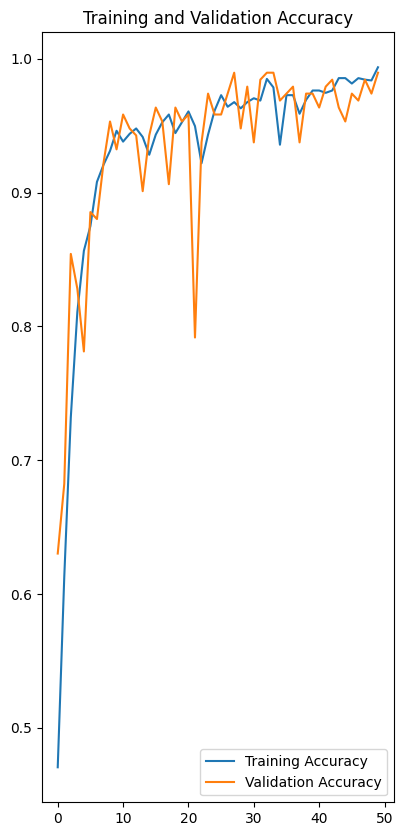

In [103]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label : Potato___Late_blight
1/1 [==============================] - 0s 276ms/step
Predicted label : Potato___Early_blight


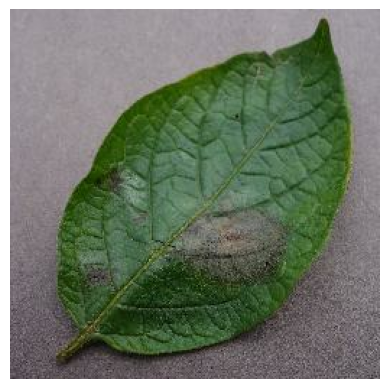

In [123]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    
    first_image= images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    
   
    plt.imshow(first_image)
    plt.axis("off") # turn off the axis, to get rid of clusters
    print("first image to predict")
    print("actual label :", class_names[first_label])
    
    batch_prediction = model.predict(images_batch) # this is the prediction for 32 images
    print("Predicted label :" , class_names[np.argmax(batch_prediction[0])]) # we are finding the max probability in the softmax numpy array, it would return the index

In [124]:
# confidence score

def predict (model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # to create a batch
    
    predictions = model.predict(img_array) # called predict functions
    
    predicted_class = class_names[np.argmax(predictions[0])] # no find the confidence
    confidence= round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence


1/1 [==============================] - 0s 34ms/step


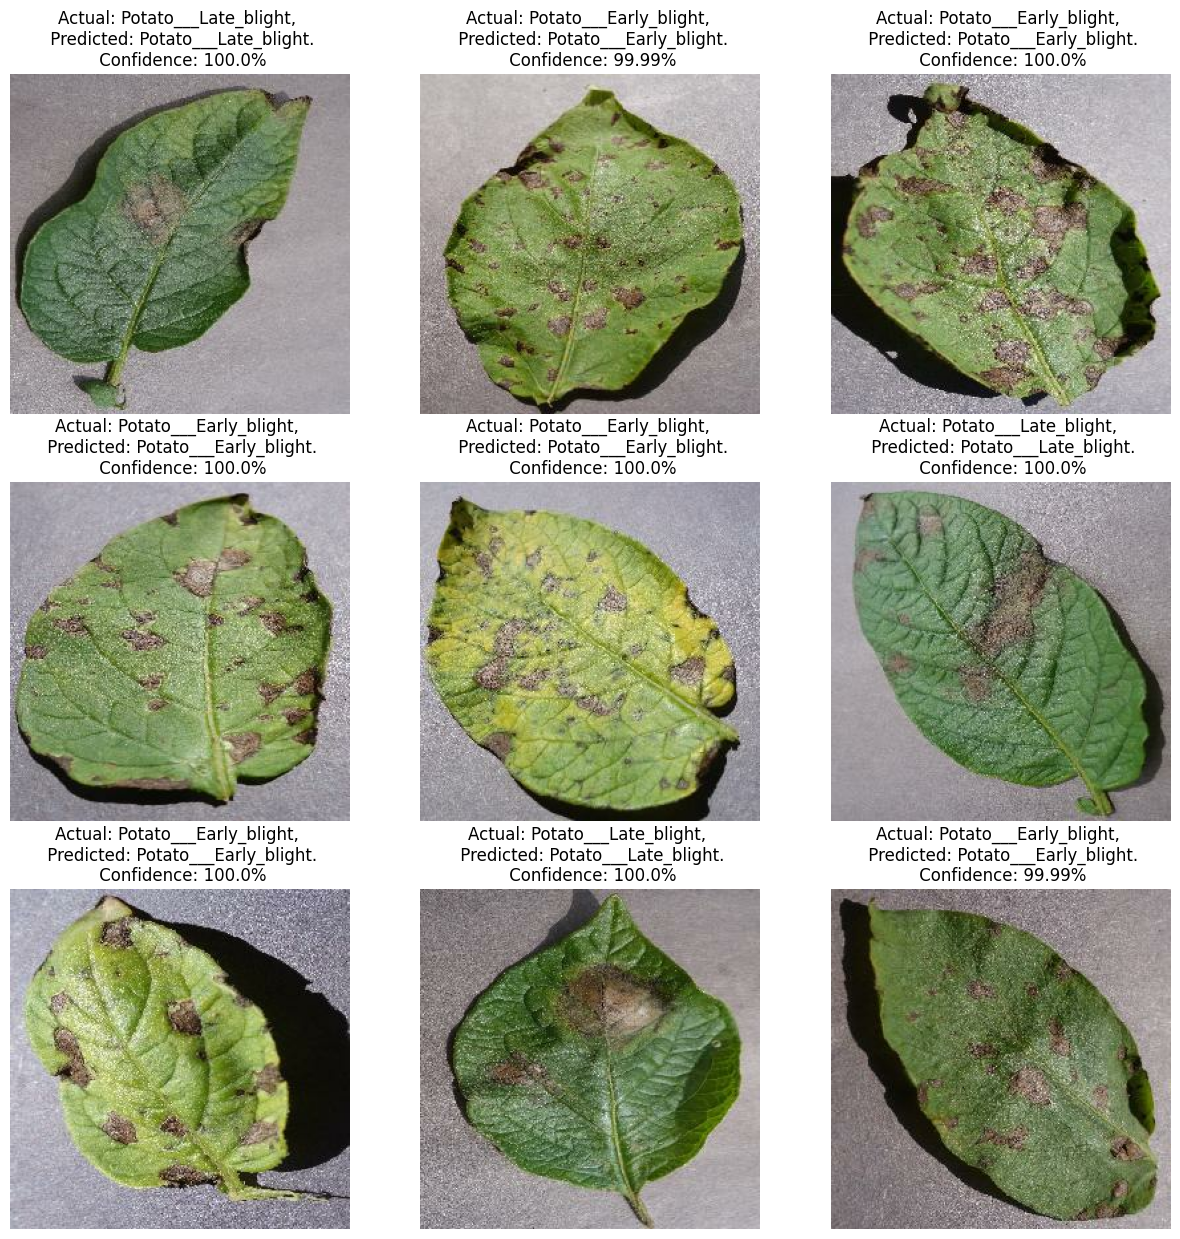

In [125]:
plt.figure(figsize=(15,15)) # increased image size, to see the images correctly

for images, labels in test_ds.take(1):
    for i in range(9): # thought of ploting 12 images out of the whole batch
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%") # used python's format string, to display just the actual label
        plt.axis("off") # turn off the axis, to get rid of clusters
        

In [127]:
model_version=1
model.save(f"../models/{model_version}") # we can make changes in the model architechture and save it in models

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


We may do the same for all other stuff like tomatoes, potatoes, etc. It would be fun to extend the code further